## 01__remap_peaks

in this notebook, i re-classify regions based on their maximum CAGE read counts. if regions have < 10 maximum CAGE read counts, they are classified as "no CAGE activity". otherwise, they are classified as a TSS. the biotype of these re-classified TSSs is assigned to be the biotype of the orthologous TSS in the other species.

i also clean up the TSS map to make the supplemental table S2.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## functions

In [3]:
def cleaner_biotype(row, biotype_col):
    if row[biotype_col] in ["protein_coding", "div_pc", "mRNA"]:
        return "mRNA"
    elif row[biotype_col] == "intergenic":
        return "lncRNA"
    elif row[biotype_col] in ["antisense", "div_lnc", "divergent", "lncRNA"]:
        return "lncRNA"
    elif row[biotype_col] == "enhancer" or row[biotype_col] == "eRNA":
        return "eRNA"
    elif row[biotype_col] in ["no cage activity", "no CAGE activity"]:
        return "no CAGE activity"
    else:
        return "other"

In [4]:
def reclassify_biotype(row, biotype_col1, biotype_col2, cage_col):
    if row["seq_orth"]:
        if row[biotype_col1] == "no CAGE activity":
            if row[cage_col] < 10:
                return "no CAGE activity"
            else:
                return row[biotype_col2]
        else:
            return row[biotype_col1]
    else:
        return "no CAGE activity"

## variables

In [5]:
human_master_f = "../../../data/01__design/00__genome_list/hg19.master_list.txt.gz"
mouse_master_f = "../../../data/01__design/00__genome_list/mm9.master_list.txt.gz"

In [6]:
human_cage_f = "../../../misc/02__cage_reads/hg19_max_counts_oligo.bed"
mouse_cage_f = "../../../misc/02__cage_reads/mm9_max_counts_oligo.bed"

## 1. import data

In [7]:
human_master = pd.read_table(human_master_f, sep="\t")
human_master["start_tss_hg19"] = human_master["start_tss_hg19"].astype(str)
human_master["end_tss_hg19"] = human_master["end_tss_hg19"].astype(str)
human_master.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,name_tss_hg19,score_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,seq_orth,cage_orth,...,score_peak_mm9,cage_id_mm9,biotype_mm9,stem_exp_mm9,avg_exp_mm9,har,repeat_hg19,repeat_mm9,repeat_status,remap_status
0,chr1,564588,564589,"ENSG00000225972.1,ENSG00000225630.1",2398,+,"chr1:564571..564600,+",multi-mapped,False,False,...,no cage activity,no cage activity,no cage activity,no cage activity,no cage activity,False,NaN,NaN,no repeats,remap fail
1,chr1,564645,564646,"ENSG00000225972.1,ENSG00000225630.1",220,+,"chr1:564639..564649,+",multi-mapped,False,False,...,no cage activity,no cage activity,no cage activity,no cage activity,no cage activity,False,NaN,NaN,no repeats,remap fail
2,chr1,565269,565270,"ENSG00000225972.1,ENSG00000225630.1",535,+,"chr1:565266..565278,+",multi-mapped,False,False,...,no cage activity,no cage activity,no cage activity,no cage activity,no cage activity,False,NaN,NaN,no repeats,remap fail
3,chr1,565480,565481,"ENSG00000237973.1,ENSG00000225630.1",106,+,"chr1:565478..565483,+",multi-mapped,False,False,...,no cage activity,no cage activity,no cage activity,no cage activity,no cage activity,False,NaN,NaN,no repeats,remap fail
4,chr1,565523,565524,"ENSG00000237973.1,ENSG00000225630.1",3594,+,"chr1:565509..565541,+",multi-mapped,False,False,...,no cage activity,no cage activity,no cage activity,no cage activity,no cage activity,False,NaN,NaN,no repeats,remap fail


In [8]:
mouse_master = pd.read_table(mouse_master_f, sep="\t")
mouse_master["start_tss_mm9"] = mouse_master["start_tss_mm9"].astype(str)
mouse_master["end_tss_mm9"] = mouse_master["end_tss_mm9"].astype(str)
mouse_master.head()

,chr_tss_mm9,start_tss_mm9,end_tss_mm9,name_tss_mm9,score_tss_mm9,strand_tss_mm9,cage_id_mm9,biotype_mm9,seq_orth,cage_orth,...,score_peak_hg19,cage_id_hg19,biotype_hg19,stem_exp_hg19,avg_exp_hg19,har,repeat_mm9,repeat_hg19,repeat_status,remap_status
0,chr1,3309585,3309586,unassigned,153,-,"chr1:3309585..3309588,-",unassigned,False,False,...,no cage activity,no cage activity,no cage activity,no cage activity,no cage activity,False,NaN,NaN,no repeats,NaN
1,chr1,3367867,3367868,ENSMUSG00000104017.1,569,-,"chr1:3367867..3367870,-",other_noncoding,False,False,...,no cage activity,no cage activity,no cage activity,no cage activity,no cage activity,False,NaN,NaN,no repeats,NaN
2,chr1,3479231,3479232,unassigned,163,-,"chr1:3479230..3479234,-",unassigned,False,False,...,no cage activity,no cage activity,no cage activity,no cage activity,no cage activity,False,Lx2A1,NaN,repeat,NaN
3,chr1,3644977,3644978,unassigned,493,-,"chr1:3644976..3644980,-",unassigned,True,False,...,no cage activity,no cage activity,no cage activity,no cage activity,no cage activity,False,NaN,NaN,no repeats,NaN
4,chr1,3657916,3657917,unassigned,904,-,"chr1:3657915..3657919,-",unassigned,False,False,...,no cage activity,no cage activity,no cage activity,no cage activity,no cage activity,False,AT_rich,NaN,repeat,NaN


In [9]:
human_cage = pd.read_table(human_cage_f, sep="\t", header=None)
human_cage.columns = ["chr", "start", "end", "name", "score", "strand", "max_cage_hg19"]
human_cage.head()

,chr,start,end,name,score,strand,max_cage_hg19
0,chr1,29469,29569,"MOUSE_CAGE_ID__chr17:66460856..66460864,-",0,+,0
1,chr1,868880,868980,"MOUSE_CAGE_ID__chr4:155629762..155629775,-",0,+,1
2,chr1,869162,869262,"HUMAN_CAGE_ID__chr1:869192..869225,+",0,+,46
3,chr1,869275,869375,"HUMAN_CAGE_ID__chr1:869322..869329,+",0,+,119
4,chr1,869275,869375,"MOUSE_CAGE_ID__chr4:155629436..155629453,-",0,+,119


In [10]:
mouse_cage = pd.read_table(mouse_cage_f, sep="\t", header=None)
mouse_cage.columns = ["chr", "start", "end", "name", "score", "strand", "max_cage_mm9"]
mouse_cage.head()

,chr,start,end,name,score,strand,max_cage_mm9
0,chr1,3202754,3202854,MOUSE_CAGE_ID__chr1:3202802-3203164,0,-,15
1,chr1,3599945,3600045,"HUMAN_CAGE_ID__chr8:56074008..56074016,+",0,-,5
2,chr1,3644928,3645028,"MOUSE_CAGE_ID__chr1:3644976..3644980,-",0,-,630
3,chr1,3661415,3661515,"HUMAN_CAGE_ID__chr8:56015008..56015048,+",0,-,54
4,chr1,3661754,3661854,"HUMAN_CAGE_ID__chr8:56014575..56014610,+",0,-,439


In [11]:
human_cage[human_cage["name"].str.contains("chr8:55389317-55389516")]

,chr,start,end,name,score,strand,max_cage_hg19
161733,chr8,55389466,55389566,HUMAN_CAGE_ID__chr8:55389317-55389516,0,+,7
337649,chr8,55389274,55389374,HUMAN_CAGE_ID__chr8:55389317-55389516,0,-,36


In [12]:
mouse_cage[mouse_cage["name"].str.contains("chr8:55389317-55389516")]

,chr,start,end,name,score,strand,max_cage_mm9
26,chr1,4461415,4461515,HUMAN_CAGE_ID__chr8:55389317-55389516,0,-,1
174107,chr1,4461603,4461703,HUMAN_CAGE_ID__chr8:55389317-55389516,0,+,7


In [13]:
human_master[human_master["cage_id_hg19"] == "chr8:55389317-55389516"][["start_tss_hg19", "end_tss_hg19", "strand_tss_hg19", "start_tss_mm9", "end_tss_mm9", "strand_tss_mm9"]]

,start_tss_hg19,end_tss_hg19,strand_tss_hg19,start_tss_mm9,end_tss_mm9,strand_tss_mm9
257449,55389323,55389324,-,4461652,4461653,+
322739,55389515,55389516,+,4461464,4461465,-


## 2. parse cage count files

In [14]:
human_cage["start"] = human_cage["start"] + 49
human_cage["end"] = human_cage["end"] - 50
human_cage["start"] = human_cage["start"].astype(str)
human_cage["end"] = human_cage["end"].astype(str)
human_cage["orig_species"] = human_cage["name"].str.split("__", expand=True)[0]
human_cage["cage_id"] = human_cage["name"].str.split("__", expand=True)[1]
human_cage.head()

,chr,start,end,name,score,strand,max_cage_hg19,orig_species,cage_id
0,chr1,29518,29519,"MOUSE_CAGE_ID__chr17:66460856..66460864,-",0,+,0,MOUSE_CAGE_ID,"chr17:66460856..66460864,-"
1,chr1,868929,868930,"MOUSE_CAGE_ID__chr4:155629762..155629775,-",0,+,1,MOUSE_CAGE_ID,"chr4:155629762..155629775,-"
2,chr1,869211,869212,"HUMAN_CAGE_ID__chr1:869192..869225,+",0,+,46,HUMAN_CAGE_ID,"chr1:869192..869225,+"
3,chr1,869324,869325,"HUMAN_CAGE_ID__chr1:869322..869329,+",0,+,119,HUMAN_CAGE_ID,"chr1:869322..869329,+"
4,chr1,869324,869325,"MOUSE_CAGE_ID__chr4:155629436..155629453,-",0,+,119,MOUSE_CAGE_ID,"chr4:155629436..155629453,-"


In [15]:
orig_human_cage_hg19 = human_cage[human_cage["orig_species"].str.contains("HUMAN")][["cage_id", "chr", 
                                                                                     "start", "end", "strand",
                                                                                     "max_cage_hg19"]].drop_duplicates()
orig_human_cage_hg19.columns = ["cage_id_hg19", "chr_tss_hg19", "start_tss_hg19", "end_tss_hg19", 
                                "strand_tss_hg19", "max_cage_hg19"]
orig_human_cage_hg19.head()

,cage_id_hg19,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,max_cage_hg19
2,"chr1:869192..869225,+",chr1,869211,869212,+,46
3,"chr1:869322..869329,+",chr1,869324,869325,+,119
7,"chr1:895930..896033,+",chr1,896012,896013,+,2831
10,"chr1:901847..901907,+",chr1,901883,901884,+,2023
13,"chr1:936318..936336,+",chr1,936325,936326,+,329


In [16]:
orig_mouse_cage_hg19 = human_cage[human_cage["orig_species"].str.contains("MOUSE")][["cage_id", "chr", 
                                                                                     "start", "end", "strand",
                                                                                     "max_cage_hg19"]].drop_duplicates()
orig_mouse_cage_hg19.columns = ["cage_id_mm9", "chr_tss_hg19", "start_tss_hg19", "end_tss_hg19", 
                                "strand_tss_hg19", "max_cage_hg19"]
orig_mouse_cage_hg19.head()

,cage_id_mm9,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,max_cage_hg19
0,"chr17:66460856..66460864,-",chr1,29518,29519,+,0
1,"chr4:155629762..155629775,-",chr1,868929,868930,+,1
4,"chr4:155629436..155629453,-",chr1,869324,869325,+,119
5,"chr4:155628652..155628671,-",chr1,871182,871183,+,28
6,"chr4:155628616..155628643,-",chr1,871206,871207,+,28


In [17]:
mouse_cage["start"] = mouse_cage["start"] + 49
mouse_cage["end"] = mouse_cage["end"] - 50
mouse_cage["start"] = mouse_cage["start"].astype(str)
mouse_cage["end"] = mouse_cage["end"].astype(str)
mouse_cage["orig_species"] = mouse_cage["name"].str.split("__", expand=True)[0]
mouse_cage["cage_id"] = mouse_cage["name"].str.split("__", expand=True)[1]
mouse_cage.head()

,chr,start,end,name,score,strand,max_cage_mm9,orig_species,cage_id
0,chr1,3202803,3202804,MOUSE_CAGE_ID__chr1:3202802-3203164,0,-,15,MOUSE_CAGE_ID,chr1:3202802-3203164
1,chr1,3599994,3599995,"HUMAN_CAGE_ID__chr8:56074008..56074016,+",0,-,5,HUMAN_CAGE_ID,"chr8:56074008..56074016,+"
2,chr1,3644977,3644978,"MOUSE_CAGE_ID__chr1:3644976..3644980,-",0,-,630,MOUSE_CAGE_ID,"chr1:3644976..3644980,-"
3,chr1,3661464,3661465,"HUMAN_CAGE_ID__chr8:56015008..56015048,+",0,-,54,HUMAN_CAGE_ID,"chr8:56015008..56015048,+"
4,chr1,3661803,3661804,"HUMAN_CAGE_ID__chr8:56014575..56014610,+",0,-,439,HUMAN_CAGE_ID,"chr8:56014575..56014610,+"


In [18]:
orig_mouse_cage_mm9 = mouse_cage[mouse_cage["orig_species"].str.contains("MOUSE")][["cage_id", "chr", 
                                                                                    "start", "end", "strand",
                                                                                    "max_cage_mm9"]].drop_duplicates()
orig_mouse_cage_mm9.columns = ["cage_id_mm9", "chr_tss_mm9", "start_tss_mm9", "end_tss_mm9", 
                               "strand_tss_mm9", "max_cage_mm9"]
orig_mouse_cage_mm9.head()

,cage_id_mm9,chr_tss_mm9,start_tss_mm9,end_tss_mm9,strand_tss_mm9,max_cage_mm9
0,chr1:3202802-3203164,chr1,3202803,3202804,-,15
2,"chr1:3644976..3644980,-",chr1,3644977,3644978,-,630
6,"chr1:3661752..3661814,-",chr1,3661803,3661804,-,439
7,"chr1:3661851..3661889,-",chr1,3661874,3661875,-,475
12,"chr1:4350318..4350327,-",chr1,4350322,4350323,-,494


In [19]:
orig_human_cage_mm9 = mouse_cage[mouse_cage["orig_species"].str.contains("HUMAN")][["cage_id", "chr", 
                                                                                    "start", "end", "strand",
                                                                                    "max_cage_mm9"]].drop_duplicates()
orig_human_cage_mm9.columns = ["cage_id_hg19", "chr_tss_mm9", "start_tss_mm9", "end_tss_mm9", 
                               "strand_tss_mm9", "max_cage_mm9"]
orig_human_cage_mm9.head()

,cage_id_hg19,chr_tss_mm9,start_tss_mm9,end_tss_mm9,strand_tss_mm9,max_cage_mm9
1,"chr8:56074008..56074016,+",chr1,3599994,3599995,-,5
3,"chr8:56015008..56015048,+",chr1,3661464,3661465,-,54
4,"chr8:56014575..56014610,+",chr1,3661803,3661804,-,439
5,"chr8:56014644..56014710,+",chr1,3661803,3661804,-,439
8,chr8:55914655-55915024,chr1,3810313,3810314,-,1


In [20]:
orig_human_cage_hg19[orig_human_cage_hg19["cage_id_hg19"] == "chr10:104210390..104210444,+"]

,cage_id_hg19,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,max_cage_hg19
23843,"chr10:104210390..104210444,+",chr10,104210396,104210397,+,1416


In [21]:
orig_human_cage_mm9[orig_human_cage_mm9["cage_id_hg19"] == "chr10:104210390..104210444,+"]

,cage_id_hg19,chr_tss_mm9,start_tss_mm9,end_tss_mm9,strand_tss_mm9,max_cage_mm9
86637,"chr10:104210390..104210444,+",chr19,46423491,46423492,-,727
262962,"chr10:104210390..104210444,+",chr19,46423549,46423550,+,1517


## 3. merge cage counts with master files

In [22]:
orig_human = orig_human_cage_hg19.merge(orig_human_cage_mm9, on=["cage_id_hg19"], how="left")
print(len(orig_human))
orig_human.sample(5)

244095


,cage_id_hg19,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,max_cage_hg19,chr_tss_mm9,start_tss_mm9,end_tss_mm9,strand_tss_mm9,max_cage_mm9
18997,chr11:12188567-12188982,chr11,12188745,12188746,+,18,chr7,119420088,119420089,-,2
141397,"chr11:9927546..9927569,-",chr11,9927548,9927549,-,392,chr7,117545591,117545592,-,5
158187,chr14:62026213-62026731,chr14,62026454,62026455,-,65,chr12,74889114,74889115,+,1
200172,"chr3:48632723..48632770,-",chr3,48632731,48632732,-,5919,chr9,108855630,108855631,+,12306
207550,chr4:67972662-67972987,chr4,67972663,67972664,-,4,chr5,86186103,86186104,+,3


In [23]:
orig_human[orig_human["cage_id_hg19"] == "chr10:104210390..104210444,+"]

,cage_id_hg19,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,max_cage_hg19,chr_tss_mm9,start_tss_mm9,end_tss_mm9,strand_tss_mm9,max_cage_mm9
16523,"chr10:104210390..104210444,+",chr10,104210396,104210397,+,1416,chr19,46423491,46423492,-,727
16524,"chr10:104210390..104210444,+",chr10,104210396,104210397,+,1416,chr19,46423549,46423550,+,1517


In [24]:
orig_mouse = orig_mouse_cage_hg19.merge(orig_mouse_cage_mm9, on=["cage_id_mm9"], how="left")
print(len(orig_mouse))
orig_mouse.sample(5)

200601


,cage_id_mm9,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,max_cage_hg19,chr_tss_mm9,start_tss_mm9,end_tss_mm9,strand_tss_mm9,max_cage_mm9
58319,"chr2:153825958..153825965,+",chr20,31748227,31748228,+,1,chr2,153825960,153825961,+,28
77233,"chr18:52688449..52688468,+",chr5,121413158,121413159,+,188,chr18,52688463,52688464,+,4759
173048,"chr3:130859273..130859284,+",chr4,109038318,109038319,-,2,chr3,130859278,130859279,+,189
104843,"chr3:122207577..122207584,+",chr1,94058270,94058271,-,7,chr3,122207581,122207582,+,178
56280,"chr1:74589455..74589492,+",chr2,219472621,219472622,+,2592,chr1,74589466,74589467,+,1752


In [25]:
print(len(human_master))
human_master_cage = human_master.merge(orig_human, on=["cage_id_hg19", "chr_tss_hg19", "start_tss_hg19",
                                                       "end_tss_hg19", "strand_tss_hg19", "chr_tss_mm9",
                                                       "start_tss_mm9", "end_tss_mm9", "strand_tss_mm9"], how="left")
print(len(human_master))
human_master_cage.sample(5)

338191
338191


,chr_tss_hg19,start_tss_hg19,end_tss_hg19,name_tss_hg19,score_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,seq_orth,cage_orth,...,biotype_mm9,stem_exp_mm9,avg_exp_mm9,har,repeat_hg19,repeat_mm9,repeat_status,remap_status,max_cage_hg19,max_cage_mm9
307811,chr4,15418788,15418789,chr4:15418390-15418789__POSITIVE,2,+,chr4:15418390-15418789,enhancer,False,False,...,no cage activity,no cage activity,no cage activity,False,L1MB5,NaN,repeat,NaN,NaN,NaN
76543,chr17,37856270,37856271,unassigned,32834,+,"chr17:37856253..37856296,+",unassigned,True,True,...,protein_coding,2.465,10.04,False,(GGA)n,NaN,repeat,NaN,18568.0,4021.0
225488,chr18,40017689,40017690,chr18:40017627-40017927__NEGATIVE,4,-,chr18:40017627-40017927,enhancer,True,False,...,no cage activity,no cage activity,no cage activity,False,NaN,NaN,no repeats,NaN,21.0,2.0
27656,chr11,1955011,1955012,unassigned,1680,+,"chr11:1954969..1955018,+",unassigned,True,True,...,unassigned,0.0,0.31,False,NaN,NaN,no repeats,NaN,144.0,484.0
184823,chr9,5628621,5628622,unassigned,666,-,"chr9:5628611..5628632,-",unassigned,True,False,...,no cage activity,no cage activity,no cage activity,False,NaN,NaN,no repeats,NaN,220.0,101.0


In [26]:
human_master_cage[human_master_cage["cage_id_hg19"] == "chr10:104210390..104210444,+"]

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,name_tss_hg19,score_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,seq_orth,cage_orth,...,biotype_mm9,stem_exp_mm9,avg_exp_mm9,har,repeat_hg19,repeat_mm9,repeat_status,remap_status,max_cage_hg19,max_cage_mm9
329274,chr10,104210396,104210397,ENSG00000269609.1,8890,+,"chr10:104210390..104210444,+",intergenic,True,True,...,enhancer,2.008,3.31585,False,NaN,NaN,no repeats,NaN,1416.0,727.0
330746,chr10,104210396,104210397,ENSG00000269609.1,8890,+,"chr10:104210390..104210444,+",intergenic,True,True,...,enhancer,2.008,3.31585,False,NaN,NaN,no repeats,NaN,1416.0,1517.0


In [27]:
human_master[human_master["cage_id_hg19"] == "chr10:104210390..104210444,+"][["cage_id_hg19", "chr_tss_hg19", "start_tss_hg19",
                                                       "end_tss_hg19", "strand_tss_hg19", "chr_tss_mm9",
                                                       "start_tss_mm9", "end_tss_mm9", "strand_tss_mm9", "biotype_hg19", "biotype_mm9"]]

,cage_id_hg19,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,chr_tss_mm9,start_tss_mm9,end_tss_mm9,strand_tss_mm9,biotype_hg19,biotype_mm9
329274,"chr10:104210390..104210444,+",chr10,104210396,104210397,+,chr19,46423491,46423492,-,intergenic,enhancer
330746,"chr10:104210390..104210444,+",chr10,104210396,104210397,+,chr19,46423549,46423550,+,intergenic,enhancer


In [28]:
print(len(mouse_master))
mouse_master_cage = mouse_master.merge(orig_mouse, on=["cage_id_mm9", "chr_tss_mm9", "start_tss_mm9",
                                                       "end_tss_mm9", "strand_tss_mm9", "chr_tss_hg19",
                                                       "start_tss_hg19", "end_tss_hg19", "strand_tss_hg19"], how="left")
print(len(mouse_master))
mouse_master_cage.sample(5)

251469
251469


,chr_tss_mm9,start_tss_mm9,end_tss_mm9,name_tss_mm9,score_tss_mm9,strand_tss_mm9,cage_id_mm9,biotype_mm9,seq_orth,cage_orth,...,biotype_hg19,stem_exp_hg19,avg_exp_hg19,har,repeat_mm9,repeat_hg19,repeat_status,remap_status,max_cage_hg19,max_cage_mm9
227109,chr3,142033603,142033604,chr3:142033240-142033604__POSITIVE,2,+,chr3:142033240-142033604,enhancer,False,False,...,no cage activity,no cage activity,no cage activity,False,ORR1E,NaN,repeat,NaN,NaN,NaN
65717,chr17,71553888,71553889,unassigned,840,+,"chr17:71553871..71553894,+",unassigned,True,False,...,no cage activity,no cage activity,no cage activity,False,NaN,NaN,no repeats,NaN,27.0,875.0
165096,chr11,119696733,119696734,chr11:119696732-119696915__NEGATIVE,2,-,chr11:119696732-119696915,enhancer,False,False,...,no cage activity,no cage activity,no cage activity,False,NaN,NaN,no repeats,NaN,NaN,NaN
202132,chr1,173403907,173403908,chr1:173403777-173403908__POSITIVE,2,+,chr1:173403777-173403908,enhancer,False,False,...,no cage activity,no cage activity,no cage activity,False,MER67B,NaN,repeat,remap fail,NaN,NaN
50620,chr15,77601645,77601646,unassigned,64,-,"chr15:77601640..77601657,-",unassigned,True,True,...,unassigned,0.181111,0.92,False,NaN,NaN,no repeats,NaN,2922.0,822.0


## 4. fix biotypes + plot CAGE peaks

In [29]:
human_master_cage["min_biotype_hg19"] = human_master_cage.apply(cleaner_biotype, biotype_col="biotype_hg19", axis=1)
human_master_cage["min_biotype_mm9"] = human_master_cage.apply(cleaner_biotype, biotype_col="biotype_mm9", axis=1)
mouse_master_cage["min_biotype_mm9"] = mouse_master_cage.apply(cleaner_biotype, biotype_col="biotype_mm9", axis=1)
mouse_master_cage["min_biotype_hg19"] = mouse_master_cage.apply(cleaner_biotype, biotype_col="biotype_hg19", axis=1)

In [30]:
human_master_cage[human_master_cage["cage_id_hg19"] == "chr1:203273760..203273784,-"]

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,name_tss_hg19,score_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,seq_orth,cage_orth,...,avg_exp_mm9,har,repeat_hg19,repeat_mm9,repeat_status,remap_status,max_cage_hg19,max_cage_mm9,min_biotype_hg19,min_biotype_mm9
330682,chr1,203273779,203273780,ENSG00000233791.1,851,-,"chr1:203273760..203273784,-",div_lnc,True,True,...,0.12038099999999999,False,NaN,NaN,no repeats,NaN,279.0,31.0,lncRNA,eRNA


In [31]:
human_seq = human_master_cage[human_master_cage["seq_orth"]]
len(human_seq)

195110

In [32]:
mouse_seq = mouse_master_cage[mouse_master_cage["seq_orth"]]
len(mouse_seq)

163131

In [33]:
order = ["eRNA", "lncRNA", "mRNA"]

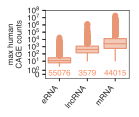

In [34]:
fig = plt.figure(figsize=(1.5, 1.25))

ax = sns.boxplot(data=human_seq, x="min_biotype_hg19", y="max_cage_hg19", order=order, 
                 color=sns.color_palette("Set2")[1], flierprops = dict(marker='o', markersize=5))
mimic_r_boxplot(ax)

ax.set_xticklabels(order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_yscale("symlog")
ax.set_ylabel("max human\nCAGE counts")

for i, label in enumerate(order):
    n = len(human_seq[human_seq["min_biotype_hg19"] == label])
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=sns.color_palette("Set2")[1], size=fontsize)

ax.set_ylim((-1, 100000000))
plt.show()
#fig.savefig("human_biotype_cage.pdf", dpi="figure", bbox_inches="tight")
plt.close()

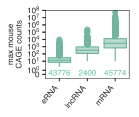

In [35]:
fig = plt.figure(figsize=(1.5, 1.25))

ax = sns.boxplot(data=mouse_seq, x="min_biotype_mm9", y="max_cage_mm9", order=order, 
                 color=sns.color_palette("Set2")[0], flierprops = dict(marker='o', markersize=5))
mimic_r_boxplot(ax)

ax.set_xticklabels(order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_yscale("symlog")
ax.set_ylabel("max mouse\nCAGE counts")

for i, label in enumerate(order):
    n = len(mouse_seq[mouse_seq["min_biotype_mm9"] == label])
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=sns.color_palette("Set2")[0], size=fontsize)

ax.set_ylim((-1, 100000000))
plt.show()
#fig.savefig("mouse_biotype_cage.pdf", dpi="figure", bbox_inches="tight")
plt.close()

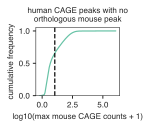

In [36]:
fig = plt.figure(figsize=(1.5, 1.25))

ax = sns.kdeplot(np.log10(human_seq[human_seq["min_biotype_mm9"] == "no CAGE activity"]["max_cage_mm9"]+1),
                  color=sns.color_palette("Set2")[0], cumulative=True)

ax.set_ylabel("cumulative frequency")
ax.set_xlabel("log10(max mouse CAGE counts + 1)")
ax.set_title("human CAGE peaks with no\northologous mouse peak")
ax.get_legend().remove()

ax.axvline(x=np.log10(10+1), color="black", linestyle="dashed")

#fig.savefig("mouse_no_peak_counts.pdf", dpi="figure", bbox_inches="tight")

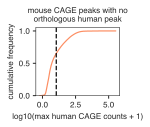

In [37]:
fig = plt.figure(figsize=(1.5, 1.25))

ax = sns.kdeplot(np.log10(mouse_seq[mouse_seq["min_biotype_hg19"] == "no CAGE activity"]["max_cage_hg19"]+1),
                  color=sns.color_palette("Set2")[1], cumulative=True)

ax.set_ylabel("cumulative frequency")
ax.set_xlabel("log10(max human CAGE counts + 1)")
ax.set_title("mouse CAGE peaks with no\northologous human peak")
ax.get_legend().remove()

ax.axvline(x=np.log10(10+1), color="black", linestyle="dashed")

#fig.savefig("human_no_peak_counts.pdf", dpi="figure", bbox_inches="tight")

## 5. re-classify CAGE peaks
anthing ≥ 10 reads in the other species is considered a CAGE peak

In [38]:
human_master_cage["new_biotype_mm9"] = human_master_cage.apply(reclassify_biotype, biotype_col1="min_biotype_mm9",
                                                               biotype_col2="min_biotype_hg19", 
                                                               cage_col="max_cage_mm9", axis=1)
human_master_cage.sample(5)

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,name_tss_hg19,score_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,seq_orth,cage_orth,...,har,repeat_hg19,repeat_mm9,repeat_status,remap_status,max_cage_hg19,max_cage_mm9,min_biotype_hg19,min_biotype_mm9,new_biotype_mm9
97953,chr2,24930427,24930428,unassigned,1149,+,"chr2:24930425..24930435,+",unassigned,True,False,...,False,NaN,NaN,no repeats,NaN,622.0,43.0,other,no CAGE activity,other
119195,chr21,35894004,35894005,unassigned,297,-,"chr21:35893999..35894014,-",unassigned,False,False,...,False,NaN,NaN,no repeats,NaN,NaN,NaN,other,no CAGE activity,no CAGE activity
53820,chr14,24664646,24664647,unassigned,93009,-,"chr14:24664616..24664690,-",unassigned,True,True,...,False,NaN,NaN,no repeats,NaN,20755.0,14971.0,other,mRNA,mRNA
224653,chr17,79926021,79926022,chr17:79925685-79926075__NEGATIVE,2,-,chr17:79925685-79926075,enhancer,False,False,...,False,GC_rich,NaN,repeat,remap fail,NaN,NaN,eRNA,no CAGE activity,no CAGE activity
7643,chr1,94502515,94502516,unassigned,138,+,"chr1:94502511..94502519,+",unassigned,True,False,...,False,NaN,NaN,no repeats,NaN,70.0,1.0,other,no CAGE activity,no CAGE activity


In [39]:
human_master_cage[human_master_cage["cage_id_hg19"] == "chr17:43325288..43325306,+"]

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,name_tss_hg19,score_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,seq_orth,cage_orth,...,har,repeat_hg19,repeat_mm9,repeat_status,remap_status,max_cage_hg19,max_cage_mm9,min_biotype_hg19,min_biotype_mm9,new_biotype_mm9
78093,chr17,43325300,43325301,ENSG00000267278.1,3825,+,"chr17:43325288..43325306,+",div_upep,True,False,...,False,NaN,NaN,no repeats,NaN,1360.0,4.0,other,no CAGE activity,no CAGE activity


In [40]:
mouse_master_cage["new_biotype_hg19"] = mouse_master_cage.apply(reclassify_biotype, biotype_col1="min_biotype_hg19",
                                                                biotype_col2="min_biotype_mm9", 
                                                                cage_col="max_cage_hg19", axis=1)
mouse_master_cage.sample(5)

,chr_tss_mm9,start_tss_mm9,end_tss_mm9,name_tss_mm9,score_tss_mm9,strand_tss_mm9,cage_id_mm9,biotype_mm9,seq_orth,cage_orth,...,har,repeat_mm9,repeat_hg19,repeat_status,remap_status,max_cage_hg19,max_cage_mm9,min_biotype_mm9,min_biotype_hg19,new_biotype_hg19
28046,chr11,107209515,107209516,unassigned,843,-,"chr11:107209509..107209527,-",unassigned,True,False,...,False,NaN,NaN,no repeats,NaN,4.0,386.0,other,no CAGE activity,no CAGE activity
3947,chr1,89024269,89024270,unassigned,46,+,"chr1:89024269..89024270,+",unassigned,True,False,...,False,NaN,NaN,no repeats,NaN,15.0,85.0,other,no CAGE activity,other
35037,chr12,113842250,113842251,unassigned,666,+,"chr12:113842243..113842256,+",unassigned,True,True,...,False,NaN,NaN,no repeats,NaN,5616.0,1440.0,other,other,other
87265,chr2,162888098,162888099,unassigned,116,+,"chr2:162888093..162888108,+",unassigned,True,False,...,False,NaN,NaN,no repeats,NaN,1.0,187.0,other,no CAGE activity,no CAGE activity
71332,chr19,4558009,4558010,unassigned,120,+,"chr19:4558007..4558011,+",unassigned,True,False,...,False,NaN,NaN,no repeats,NaN,3.0,221.0,other,no CAGE activity,no CAGE activity


In [41]:
mouse_master_cage[mouse_master_cage["cage_id_mm9"] == "chr13:46058556-46059202"]

,chr_tss_mm9,start_tss_mm9,end_tss_mm9,name_tss_mm9,score_tss_mm9,strand_tss_mm9,cage_id_mm9,biotype_mm9,seq_orth,cage_orth,...,har,repeat_mm9,repeat_hg19,repeat_status,remap_status,max_cage_hg19,max_cage_mm9,min_biotype_mm9,min_biotype_hg19,new_biotype_hg19
167809,chr13,46059088,46059089,chr13:46058556-46059202__NEGATIVE,35,-,chr13:46058556-46059202,enhancer,True,True,...,False,NaN,NaN,no repeats,NaN,2352.0,1279.0,eRNA,lncRNA,lncRNA
210730,chr13,46059110,46059111,chr13:46058556-46059202__POSITIVE,35,+,chr13:46058556-46059202,enhancer,True,True,...,False,NaN,NaN,no repeats,NaN,2352.0,16.0,eRNA,lncRNA,lncRNA


In [42]:
human_seq = human_master_cage[human_master_cage["seq_orth"]]
human_seq.min_biotype_mm9.value_counts()

no CAGE activity    119967
mRNA                 37048
other                28274
eRNA                  9145
lncRNA                 676
Name: min_biotype_mm9, dtype: int64

In [43]:
human_seq.new_biotype_mm9.value_counts()

no CAGE activity    78076
other               57617
mRNA                43995
eRNA                13711
lncRNA               1711
Name: new_biotype_mm9, dtype: int64

In [44]:
mouse_seq = mouse_master_cage[mouse_master_cage["seq_orth"]]
mouse_seq.min_biotype_hg19.value_counts()

no CAGE activity    89564
mRNA                33440
other               30402
eRNA                 8809
lncRNA                916
Name: min_biotype_hg19, dtype: int64

In [45]:
mouse_seq.new_biotype_hg19.value_counts()

no CAGE activity    57865
other               51717
mRNA                39398
eRNA                12626
lncRNA               1525
Name: new_biotype_hg19, dtype: int64

In [46]:
human_master_cage.cage_orth.value_counts()

False    263048
True      75143
Name: cage_orth, dtype: int64

In [47]:
human_master_cage["cage_orth"] = human_master_cage["new_biotype_mm9"] != "no CAGE activity"
mouse_master_cage["cage_orth"] = mouse_master_cage["new_biotype_hg19"] != "no CAGE activity"

In [48]:
human_master_cage.cage_orth.value_counts()

False    221157
True     117034
Name: cage_orth, dtype: int64

## 6. make new peak files

In [49]:
human_master_cage["seq_orth_bin"] = human_master_cage["seq_orth"].astype(int)
human_master_cage["cage_orth_bin"] = human_master_cage["cage_orth"].astype(int)
human_master_cage = human_master_cage.drop_duplicates()
human_master_cage.sample(5)

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,name_tss_hg19,score_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,seq_orth,cage_orth,...,repeat_mm9,repeat_status,remap_status,max_cage_hg19,max_cage_mm9,min_biotype_hg19,min_biotype_mm9,new_biotype_mm9,seq_orth_bin,cage_orth_bin
205535,chr10,33893153,33893154,chr10:33893152-33893448__NEGATIVE,2,-,chr10:33893152-33893448,enhancer,False,False,...,NaN,repeat,NaN,NaN,NaN,eRNA,no CAGE activity,no CAGE activity,0,0
92603,chr19,40919284,40919285,ENSG00000105227.10,6687,-,"chr19:40919278..40919294,-",protein_coding,True,True,...,NaN,no repeats,NaN,3774.0,5288.0,mRNA,mRNA,mRNA,1,1
158332,chr6,34855873,34855874,unassigned,513,+,"chr6:34855868..34855885,+",unassigned,True,True,...,NaN,no repeats,NaN,398.0,68.0,other,other,other,1,1
10101,chr1,152371956,152371957,ENSG00000183586.8,23287,+,"chr1:152371942..152371975,+",pseudogene,False,False,...,NaN,no repeats,NaN,NaN,NaN,other,no CAGE activity,no CAGE activity,0,0
311326,chr5,55625201,55625202,chr5:55625061-55625202__POSITIVE,2,+,chr5:55625061-55625202,enhancer,False,False,...,NaN,repeat,NaN,NaN,NaN,eRNA,no CAGE activity,no CAGE activity,0,0


In [50]:
mouse_master_cage["seq_orth_bin"] = mouse_master_cage["seq_orth"].astype(int)
mouse_master_cage["cage_orth_bin"] = mouse_master_cage["cage_orth"].astype(int)
mouse_master_cage = mouse_master_cage.drop_duplicates()
mouse_master_cage.sample(5)

,chr_tss_mm9,start_tss_mm9,end_tss_mm9,name_tss_mm9,score_tss_mm9,strand_tss_mm9,cage_id_mm9,biotype_mm9,seq_orth,cage_orth,...,repeat_hg19,repeat_status,remap_status,max_cage_hg19,max_cage_mm9,min_biotype_mm9,min_biotype_hg19,new_biotype_hg19,seq_orth_bin,cage_orth_bin
21011,chr11,58195791,58195792,unassigned,1326,+,"chr11:58195782..58195801,+",unassigned,False,False,...,NaN,no repeats,NaN,NaN,NaN,other,no CAGE activity,no CAGE activity,0,0
97971,chr4,34899705,34899706,unassigned,1169,-,"chr4:34899705..34899713,-",unassigned,False,False,...,NaN,repeat,NaN,NaN,NaN,other,no CAGE activity,no CAGE activity,0,0
145557,chr9,40263820,40263821,unassigned,548,-,"chr9:40263815..40263826,-",unassigned,True,True,...,(TC)n,repeat,NaN,3345.0,1462.0,other,mRNA,mRNA,1,1
211519,chr13,99051456,99051457,chr13:99051165-99051457__POSITIVE,2,+,chr13:99051165-99051457,enhancer,False,False,...,NaN,repeat,NaN,NaN,NaN,eRNA,no CAGE activity,no CAGE activity,0,0
217125,chr16,92493001,92493002,chr16:92492829-92493002__POSITIVE,2,+,chr16:92492829-92493002,enhancer,False,False,...,NaN,no repeats,remap fail,NaN,NaN,eRNA,no CAGE activity,no CAGE activity,0,0


In [51]:
human_sub = human_master_cage[["cage_id_hg19", "strand_tss_hg19", "min_biotype_hg19", "seq_orth_bin", 
                               "cage_orth_bin", "new_biotype_mm9"]].drop_duplicates()
mouse_sub = mouse_master_cage[["cage_id_mm9", "strand_tss_mm9", "min_biotype_mm9", "seq_orth_bin", 
                               "cage_orth_bin", "new_biotype_hg19"]].drop_duplicates()

In [52]:
human_seq_grp = human_sub.groupby(["cage_id_hg19", "min_biotype_hg19"])["seq_orth_bin"].agg("sum").reset_index()
mouse_seq_grp = mouse_sub.groupby(["cage_id_mm9", "min_biotype_mm9"])["seq_orth_bin"].agg("sum").reset_index()
human_seq_grp.head()

,cage_id_hg19,min_biotype_hg19,seq_orth_bin
0,"chr10:100013403..100013414,-",other,1
1,chr10:100019738-100019959,eRNA,2
2,chr10:100020230-100020246,eRNA,0
3,"chr10:100027943..100027958,-",mRNA,0
4,chr10:100074404-100074582,eRNA,2


In [53]:
human_cage_grp = human_sub.groupby(["cage_id_hg19", "min_biotype_hg19"])["cage_orth_bin"].agg("sum").reset_index()
mouse_cage_grp = mouse_sub.groupby(["cage_id_mm9", "min_biotype_mm9"])["cage_orth_bin"].agg("sum").reset_index()
human_cage_grp.head()

,cage_id_hg19,min_biotype_hg19,cage_orth_bin
0,"chr10:100013403..100013414,-",other,1
1,chr10:100019738-100019959,eRNA,0
2,chr10:100020230-100020246,eRNA,0
3,"chr10:100027943..100027958,-",mRNA,0
4,chr10:100074404-100074582,eRNA,0


In [54]:
human_grp = human_seq_grp.merge(human_cage_grp, on=["cage_id_hg19", "min_biotype_hg19"], how="left")
human_grp = human_grp.merge(human_sub[["cage_id_hg19", "new_biotype_mm9"]], on="cage_id_hg19", how="left")
human_grp.sample(5)

,cage_id_hg19,min_biotype_hg19,seq_orth_bin,cage_orth_bin,new_biotype_mm9
281559,"chr7:138189217..138189221,+",other,0,0,no CAGE activity
150030,"chr1:36092856..36092860,-",other,0,0,no CAGE activity
16992,"chr11:113346113..113346125,-",mRNA,1,1,mRNA
199351,chr2:45225232-45225342,eRNA,2,0,no CAGE activity
136726,chr1:175158150-175158288,eRNA,2,2,other


In [55]:
mouse_grp = mouse_seq_grp.merge(mouse_cage_grp, on=["cage_id_mm9", "min_biotype_mm9"], how="left")
mouse_grp = mouse_grp.merge(mouse_sub[["cage_id_mm9", "new_biotype_hg19"]], on="cage_id_mm9", how="left")
mouse_grp.sample(5)

,cage_id_mm9,min_biotype_mm9,seq_orth_bin,cage_orth_bin,new_biotype_hg19
31165,chr11:98309190-98310107,eRNA,2,2,eRNA
138990,chr2:57122880-57123268,eRNA,0,0,no CAGE activity
104022,"chr19:44371122..44371143,+",other,0,0,no CAGE activity
222990,"chr8:48072237..48072245,+",mRNA,1,1,other
134928,"chr2:24206565..24206576,+",other,1,0,no CAGE activity


## 7. write files

In [56]:
human_grp.columns = ["cage_id", "biotype", "seq_ortholog", "cage_ortholog", "other_sp_biotype"]
mouse_grp.columns = ["cage_id", "biotype", "seq_ortholog", "cage_ortholog", "other_sp_biotype"]

In [57]:
human_master_f = '../../../data/01__design/00__genome_list/hg19.master_list.reclassified.txt.gz'
mouse_master_f = '../../../data/01__design/00__genome_list/mm9.master_list.reclassified.txt.gz'

In [58]:
human_peak_f = '../../../data/01__design/00__genome_list/hg19.PEAK_STATUS.txt.gz'
mouse_peak_f = '../../../data/01__design/00__genome_list/mm9.PEAK_STATUS.txt.gz'

In [59]:
human_grp.to_csv(human_peak_f, sep="\t", index=False, compression="gzip")
mouse_grp.to_csv(mouse_peak_f, sep="\t", index=False, compression="gzip")

In [60]:
human_master_cage.to_csv(human_master_f, sep="\t", index=False, compression="gzip")
mouse_master_cage.to_csv(mouse_master_f, sep="\t", index=False, compression="gzip")

## 8. fix MPRA map file

In [61]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.txt"
tss_map = pd.read_table(tss_map_f, sep="\t")
tss_map.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,stem_exp_hg19,stem_exp_mm9,har,orig_species,lift_species,oligo_type,human_type,mouse_type,hg19_id,mm9_id
0,chr1,2984981,2984982,-,"chr1:2984976..2984989,-",divergent,ENSG00000177133.6,True,True,chr4,...,0.027777800000000002,0.0175,False,human,mouse,human__divergent:mouse__divergent,divergent,divergent,h.0,m.0
1,chr1,2985002,2985003,-,"chr1:2984997..2985037,-",divergent,ENSG00000177133.6,True,True,chr4,...,0.0311111,0.0175,False,human,mouse,human__divergent:mouse__divergent,divergent,divergent,h.1,m.0
2,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",divergent,ENSG00000177133.6,True,True,chr4,...,0.07111110000000001,0.0,False,human,mouse,human__divergent:mouse__divergent,divergent,divergent,h.2,m.1
3,chr1,8086552,8086553,+,"chr1:8086546..8086571,+",divergent,ENSG00000238290.1,True,True,chr4,...,0.10444400000000001,0.0,False,human,mouse,human__divergent:mouse__antisense,divergent,antisense,h.3,m.2
4,chr1,26498322,26498323,-,"chr1:26498321..26498327,-",antisense,ENSG00000236782.1,True,True,chr4,...,0.03,0.0,False,human,mouse,human__antisense:mouse__protein_coding,antisense,protein_coding,h.4,m.3


In [62]:
len(tss_map)

3789

In [63]:
orig_human = tss_map[tss_map["orig_species"] == "human"]
orig_human["start_tss_hg19"] = orig_human["start_tss_hg19"].astype(str)
orig_human["end_tss_hg19"] = orig_human["end_tss_hg19"].astype(str)
orig_human["start_tss_mm9"] = orig_human["start_tss_mm9"].astype(str)
orig_human["end_tss_mm9"] = orig_human["end_tss_mm9"].astype(str)
print(len(orig_human))
orig_human[orig_human["cage_id_hg19"] == "chr2:42217488-42217883"]

2709


,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,stem_exp_hg19,stem_exp_mm9,har,orig_species,lift_species,oligo_type,human_type,mouse_type,hg19_id,mm9_id
1260,chr2,42217489,42217490,-,chr2:42217488-42217883,enhancer,chr2:42217488-42217883__NEGATIVE,True,True,chr17,...,0.0,0.045524800000000004,False,human,mouse,human__enhancer:mouse__enhancer,enhancer,enhancer,h.1228,m.1100
1261,chr2,42217489,42217490,-,chr2:42217488-42217883,enhancer,chr2:42217488-42217883__NEGATIVE,True,True,chr17,...,0.0,0.045524800000000004,False,human,mouse,human__enhancer:mouse__enhancer,enhancer,enhancer,h.1228,m.1265
1464,chr2,42217638,42217639,+,chr2:42217488-42217883,enhancer,chr2:42217488-42217883__POSITIVE,True,True,chr17,...,0.0,0.0455248,False,human,mouse,human__enhancer:mouse__enhancer,enhancer,enhancer,h.1418,m.1100
1465,chr2,42217638,42217639,+,chr2:42217488-42217883,enhancer,chr2:42217488-42217883__POSITIVE,True,True,chr17,...,0.0,0.0455248,False,human,mouse,human__enhancer:mouse__enhancer,enhancer,enhancer,h.1418,m.1265


In [64]:
orig_mouse = tss_map[tss_map["orig_species"] == "mouse"]
orig_mouse["start_tss_mm9"] = orig_mouse["start_tss_mm9"].astype(str)
orig_mouse["end_tss_mm9"] = orig_mouse["end_tss_mm9"].astype(str)
orig_mouse["start_tss_hg19"] = orig_mouse["start_tss_hg19"].astype(str)
orig_mouse["end_tss_hg19"] = orig_mouse["end_tss_hg19"].astype(str)
print(len(orig_mouse))

1080


In [65]:
human_master_cage_sub = human_master_cage[["cage_id_hg19", "start_tss_hg19", "end_tss_hg19", "strand_tss_hg19", 
                                           "min_biotype_hg19", "start_tss_mm9", "end_tss_mm9", "strand_tss_mm9", 
                                           "new_biotype_mm9", "max_cage_hg19", "max_cage_mm9"]].drop_duplicates()
human_master_cage_sub.columns = ["cage_id_hg19", "start_tss_hg19", "end_tss_hg19", "strand_tss_hg19", 
                                 "minimal_biotype_hg19", "start_tss_mm9", "end_tss_mm9", "strand_tss_mm9", 
                                 "minimal_biotype_mm9", "max_cage_hg19", "max_cage_mm9"]

In [66]:
mouse_master_cage_sub = mouse_master_cage[["cage_id_mm9", "start_tss_mm9", "end_tss_mm9", "strand_tss_mm9", 
                                           "min_biotype_mm9", "start_tss_hg19", "end_tss_hg19", "strand_tss_hg19", 
                                           "new_biotype_hg19", "max_cage_mm9", "max_cage_hg19"]].drop_duplicates()
mouse_master_cage_sub.columns = ["cage_id_mm9", "start_tss_mm9", "end_tss_mm9", "strand_tss_mm9", 
                                 "minimal_biotype_mm9", "start_tss_hg19", "end_tss_hg19", "strand_tss_hg19", 
                                 "minimal_biotype_hg19", "max_cage_mm9", "max_cage_hg19"]

In [67]:
mrg_human = orig_human.merge(human_master_cage_sub, on=["cage_id_hg19", "start_tss_hg19", 
                                                        "end_tss_hg19", "strand_tss_hg19",
                                                        "start_tss_mm9", "end_tss_mm9", "strand_tss_mm9"], 
                              how="left").drop_duplicates()
print(len(mrg_human))

2709


In [68]:
mrg_mouse = orig_mouse.merge(mouse_master_cage_sub, on=["cage_id_mm9", "start_tss_mm9", 
                                                        "end_tss_mm9", "strand_tss_mm9",
                                                        "start_tss_hg19", "end_tss_hg19", "strand_tss_hg19"], 
                              how="left").drop_duplicates()
print(len(mrg_mouse))

1080


In [69]:
new_map = mrg_human.append(mrg_mouse)
print(len(new_map))
new_map.sample(5)

3789


,avg_exp_hg19,avg_exp_mm9,biotype_hg19,biotype_mm9,cage_id_hg19,cage_id_mm9,cage_orth,chr_tss_hg19,chr_tss_mm9,end_tss_hg19,...,name_peak_mm9,oligo_type,orig_species,seq_orth,start_tss_hg19,start_tss_mm9,stem_exp_hg19,stem_exp_mm9,strand_tss_hg19,strand_tss_mm9
1635,0.04,no cage activity,antisense,no cage activity,"chr17:202392..202413,+",no cage activity,False,chr17,chr11,202400,...,no cage activity,human__antisense:mouse__no_CAGE,human,True,202399,75751068,0.028888900000000002,no cage activity,+,+
2131,0.08,no cage activity,intergenic,no cage activity,"chr2:74208728..74208757,-",no cage activity,False,chr2,chr6,74208734,...,no cage activity,human__intergenic:mouse__no_CAGE,human,True,74208733,83410191,0.0322222,no cage activity,-,+
245,0.47,0.07,divergent,divergent,"chr3:18486459..18486481,+","chr17:51972140..51972150,+",True,chr3,chr17,18486465,...,ENSMUSG00000103753.1,human__divergent:mouse__divergent,human,True,18486464,51972143,0.45888900000000005,0.03375,+,+
1192,0.049765300000000005,0.035479500000000004,enhancer,enhancer,chr2:64894012-64894430,chr11:20516193-20516241,True,chr2,chr11,64894305,...,chr11:20516193-20516241__NEGATIVE,human__enhancer:mouse__enhancer,human,True,64894304,20516195,0.0287066,0.0,-,-
2310,4.1,no cage activity,protein_coding,no cage activity,"chr17:30186206..30186223,-",no cage activity,False,chr17,chr11,30186212,...,no cage activity,human__protein_coding:mouse__no_CAGE,human,True,30186211,79744882,2.00444,no cage activity,-,-


some biotypes are null because these seqs were not expressed in hESCs and thus did not make it in our "master" bed file with all enhancers & TSSs (43 total)

for these, assign the original biotype that was assigned upon pool design

In [70]:
def fix_biotype(row, suff):
    if pd.isnull(row["minimal_biotype_%s" % suff]):
        return row["biotype_%s" % suff]
    else:
        return row["minimal_biotype_%s" % suff]

new_map["tmp_hg19"] = new_map.apply(fix_biotype, suff="hg19", axis=1)
new_map["tmp_mm9"] = new_map.apply(fix_biotype, suff="mm9", axis=1)

In [71]:
new_map["minimal_biotype_hg19"] = new_map.apply(cleaner_biotype, biotype_col="tmp_hg19", axis=1)
new_map["minimal_biotype_mm9"] = new_map.apply(cleaner_biotype, biotype_col="tmp_mm9", axis=1)

In [72]:
new_map[pd.isnull(new_map["minimal_biotype_hg19"])]

,avg_exp_hg19,avg_exp_mm9,biotype_hg19,biotype_mm9,cage_id_hg19,cage_id_mm9,cage_orth,chr_tss_hg19,chr_tss_mm9,end_tss_hg19,...,orig_species,seq_orth,start_tss_hg19,start_tss_mm9,stem_exp_hg19,stem_exp_mm9,strand_tss_hg19,strand_tss_mm9,tmp_hg19,tmp_mm9


In [73]:
new_map = new_map[["hg19_id", "mm9_id", "cage_id_hg19", "cage_id_mm9", "name_peak_hg19", "name_peak_mm9", 
                   "biotype_hg19", "biotype_mm9", "minimal_biotype_hg19", "minimal_biotype_mm9", "chr_tss_hg19", 
                   "start_tss_hg19", "end_tss_hg19", "strand_tss_hg19", "chr_tss_mm9", "start_tss_mm9", "end_tss_mm9", 
                   "strand_tss_mm9", "avg_exp_hg19", "avg_exp_mm9", "stem_exp_hg19", "stem_exp_mm9", "max_cage_hg19", 
                   "max_cage_mm9","orig_species", "har"]]
new_map.head()

,hg19_id,mm9_id,cage_id_hg19,cage_id_mm9,name_peak_hg19,name_peak_mm9,biotype_hg19,biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9,...,end_tss_mm9,strand_tss_mm9,avg_exp_hg19,avg_exp_mm9,stem_exp_hg19,stem_exp_mm9,max_cage_hg19,max_cage_mm9,orig_species,har
0,h.0,m.0,"chr1:2984976..2984989,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011664,+,0.1,0.43,0.027777800000000002,0.0175,367.0,2286.0,human,False
1,h.1,m.0,"chr1:2984997..2985037,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011664,+,0.29,0.43,0.0311111,0.0175,367.0,2286.0,human,False
2,h.2,m.1,"chr1:2985420..2985438,-","chr4:154011250..154011257,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011253,+,2.54,0.85,0.07111110000000001,0.0,6966.0,1361.0,human,False
3,h.3,m.2,"chr1:8086546..8086571,+","chr4:150229039..150229050,-",ENSG00000238290.1,ENSMUSG00000078492.3,divergent,antisense,lncRNA,lncRNA,...,150229045,-,0.3,0.14,0.10444400000000001,0.0,960.0,123.0,human,False
4,h.4,m.3,"chr1:26498321..26498327,-","chr4:133799669..133799683,+",ENSG00000236782.1,ENSMUSG00000086322.7,antisense,protein_coding,other,mRNA,...,133799678,+,0.19,0.25,0.03,0.0,753.0,770.0,human,False


In [74]:
new_map[new_map["cage_id_hg19"] == "chr1:203273760..203273784,-"]

,hg19_id,mm9_id,cage_id_hg19,cage_id_mm9,name_peak_hg19,name_peak_mm9,biotype_hg19,biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9,...,end_tss_mm9,strand_tss_mm9,avg_exp_hg19,avg_exp_mm9,stem_exp_hg19,stem_exp_mm9,max_cage_hg19,max_cage_mm9,orig_species,har
449,h.447,m.313,"chr1:203273760..203273784,-",chr1:135976319-135976552,ENSG00000233791.1,chr1:135976319-135976552__POSITIVE,divergent,enhancer,lncRNA,eRNA,...,135976546,+,0.23,0.12038099999999999,0.0177778,0.0283411,279.0,31.0,human,False
2663,h.447,m.3463,"chr1:203273760..203273784,-",chr1:135976319-135976552,ENSG00000233791.1,chr1:135976319-135976552__NEGATIVE,divergent,enhancer,lncRNA,eRNA,...,135976325,-,0.23,0.12038099999999999,0.0177778,0.0283411,NaN,NaN,human,False


In [75]:
print(len(new_map[pd.isnull(new_map["minimal_biotype_hg19"])]))
new_map[pd.isnull(new_map["minimal_biotype_hg19"])]

0


,hg19_id,mm9_id,cage_id_hg19,cage_id_mm9,name_peak_hg19,name_peak_mm9,biotype_hg19,biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9,...,end_tss_mm9,strand_tss_mm9,avg_exp_hg19,avg_exp_mm9,stem_exp_hg19,stem_exp_mm9,max_cage_hg19,max_cage_mm9,orig_species,har


In [76]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.RECLASSIFIED.txt"
new_map.to_csv(tss_map_f, sep="\t", index=False)

### make supplemental file tss map

In [77]:
new_map.columns

Index(['hg19_id', 'mm9_id', 'cage_id_hg19', 'cage_id_mm9', 'name_peak_hg19',
       'name_peak_mm9', 'biotype_hg19', 'biotype_mm9', 'minimal_biotype_hg19',
       'minimal_biotype_mm9', 'chr_tss_hg19', 'start_tss_hg19', 'end_tss_hg19',
       'strand_tss_hg19', 'chr_tss_mm9', 'start_tss_mm9', 'end_tss_mm9',
       'strand_tss_mm9', 'avg_exp_hg19', 'avg_exp_mm9', 'stem_exp_hg19',
       'stem_exp_mm9', 'max_cage_hg19', 'max_cage_mm9', 'orig_species', 'har'],
      dtype='object')

In [78]:
supp_table = new_map[["cage_id_hg19", "cage_id_mm9", "name_peak_hg19", "name_peak_mm9",
                      "minimal_biotype_hg19", "minimal_biotype_mm9", "chr_tss_hg19", "start_tss_hg19", 
                      "strand_tss_hg19", "chr_tss_mm9", "start_tss_mm9", "strand_tss_mm9",
                      "max_cage_hg19", "max_cage_mm9", "stem_exp_hg19", "stem_exp_mm9"]].drop_duplicates()
len(supp_table)

3737

In [79]:
supp_table.columns = ["cage_id_hg19", "cage_id_mm9", "tss_name_hg19", "tss_name_mm9", "biotype_hg19", "biotype_mm9",
                      "chr_hg19", "tss_coord_hg19", "strand_hg19", "chr_mm9", "tss_coord_mm9", "strand_mm9",
                      "max_cage_hg19", "max_cage_mm9", "stem_cage_hg19", "stem_cage_mm9"]
supp_table.head()

,cage_id_hg19,cage_id_mm9,tss_name_hg19,tss_name_mm9,biotype_hg19,biotype_mm9,chr_hg19,tss_coord_hg19,strand_hg19,chr_mm9,tss_coord_mm9,strand_mm9,max_cage_hg19,max_cage_mm9,stem_cage_hg19,stem_cage_mm9
0,"chr1:2984976..2984989,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,lncRNA,lncRNA,chr1,2984981,-,chr4,154011663,+,367.0,2286.0,0.027777800000000002,0.0175
1,"chr1:2984997..2985037,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,lncRNA,lncRNA,chr1,2985002,-,chr4,154011663,+,367.0,2286.0,0.0311111,0.0175
2,"chr1:2985420..2985438,-","chr4:154011250..154011257,+",ENSG00000177133.6,ENSMUSG00000085069.2,lncRNA,lncRNA,chr1,2985430,-,chr4,154011252,+,6966.0,1361.0,0.07111110000000001,0.0
3,"chr1:8086546..8086571,+","chr4:150229039..150229050,-",ENSG00000238290.1,ENSMUSG00000078492.3,lncRNA,lncRNA,chr1,8086552,+,chr4,150229044,-,960.0,123.0,0.10444400000000001,0.0
4,"chr1:26498321..26498327,-","chr4:133799669..133799683,+",ENSG00000236782.1,ENSMUSG00000086322.7,other,mRNA,chr1,26498322,-,chr4,133799677,+,753.0,770.0,0.03,0.0


In [80]:
supp_table.to_csv("../../../data/01__design/01__mpra_list/SuppTable_Pool.txt", sep="\t", index=False)